# LQR Controller Design for Reaction Wheel Inverted Pendulum

This notebook designs an **LQR (Linear Quadratic Regulator)** controller for a monopedal jumping robot with reaction wheel stabilization.

## System Overview
- **Plant**: Inverted pendulum (robot body) with reaction wheel actuator
- **States**: Body angle (θ), body angular velocity (θ̇), wheel angle (q_w), wheel velocity (q̇_w)
- **Control**: Torque applied to reaction wheels
- **Sensors**: IMU (pitch angle & rate) + wheel encoders (position & velocity)

## Workflow
1. **Extract robot parameters** from URDF files
2. **Visualize robot structure** in 2D and 3D
3. **Define system dynamics** (A and B matrices)
4. **Solve LQR problem** to find optimal gain matrix K
5. **Simulate controller** with ideal and noisy sensor feedback
6. **Export gains** for ROS2 implementation

---

## 1. Import Libraries and Load URDF

We use `roboticstoolbox` to parse the URDF/xacro files and extract robot parameters.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
import numpy as np
from roboticstoolbox.robot.ERobot import ERobot


urdf_path = "/Users/peeradonruengkaew/Developer/FRA502/jumping_monopedal/src/monoped_2d_description/urdf/robot_core.xacro"
links, name, urdf_string, urdf_filepath = ERobot.URDF_read(urdf_path)
for link in links:
    print(link)

Link("body_link", m=3, r=[0, 0, 0], I=[0.0112, 0.0112, 0.0112, 0, 0, 0], Jm=0, B=0, Tc=[0, 0], G=0)
Link("rw_left_link", SE3(0, 0.105, 0; -90°, -0°, 0°) ⊕ Rz(q), parent="body_link", qlim=[None, None], m=1, r=[0, 0, 0], I=[0.00576, 0.00576, 0.0112, 0, 0, 0], Jm=0, B=0, Tc=[0, 0], G=0)
Link("rw_right_link", SE3(0, -0.105, 0; 90°, -0°, 0°) ⊕ Rz(q), parent="body_link", qlim=[None, None], m=1, r=[0, 0, 0], I=[0.00576, 0.00576, 0.0112, 0, 0, 0], Jm=0, B=0, Tc=[0, 0], G=0)
Link("thigh_link", SE3(0, 0, -0.075), parent="body_link", m=0.05, r=[0, 0, -0.075], I=[0.000105, 0.000105, 2.25e-05, 0, 0, 0], Jm=0, B=0, Tc=[0, 0], G=0)
Link("shank_link", SE3(0, 0, -0.15) ⊕ tz(q), parent="thigh_link", qlim=[0, 0.1], m=0.05, r=[0, 0, -0.075], I=[9.87e-05, 9.87e-05, 1e-05, 0, 0, 0], Jm=0, B=0, Tc=[0, 0], G=0)
Link("passive_shank_link", SE3(0, 0, -0.15) ⊕ tz(q), parent="shank_link", qlim=[0, 0.1], m=0.05, r=[0, 0, -0.075], I=[9.87e-05, 9.87e-05, 1e-05, 0, 0, 0], Jm=0, B=0, Tc=[0, 0], G=0)
Link("foot_link", S

## 2. Extract Physical Parameters from URDF

Extract mass, dimensions, and inertia tensors from the parsed robot model:
- **Body**: 3.0 kg box (0.15×0.15×0.15 m)
- **Reaction wheels**: 2 wheels (1.0 kg each, radius 0.15 m, offset ±0.105 m)
- **Inertia calculation**: Uses parallel axis theorem to combine body and wheel inertias

In [50]:
# Extract physical parameters directly from parsed URDF
# Find body_link and reaction wheel links
body_link = None
rw_left = None
rw_right = None

for link in links:
    if link.name == "body_link":
        body_link = link
    elif link.name == "rw_left_link":
        rw_left = link
    elif link.name == "rw_right_link":
        rw_right = link

# Body parameters
m = body_link.m  # body mass [kg]
b_x = 0.15       # body width [m]
b_y = 0.15       # body depth [m]
b_z = 0.15       # body height [m]
l = b_z / 2      # approximate COM height from hip joint [m]
g = 9.81         # gravity [m/s^2]

# Body inertia from URDF (3x3 matrix)
# For pitch motion (rotation about Y-axis), we use Iyy (element [1,1])
print(f"Body link inertia tensor:\n{body_link.I}")
Jb_body = float(body_link.I[1, 1])  # body inertia about Y-axis [kg*m^2]

# Reaction wheel parameters
mass_rw = rw_left.m  # reaction wheel mass [kg]
rw_r = 0.15      # reaction wheel radius [m]
rw_l = 0.04      # reaction wheel thickness [m]

# Reaction wheel inertia about its spin axis (Z in wheel frame)
print(f"\nRW left inertia tensor:\n{rw_left.I}")
Jw = float(rw_left.I[2, 2])  # wheel spin inertia (Izz) [kg*m^2]

# Reaction wheel contribution to body pitch inertia
# Each wheel has inertia about pitch axis plus parallel axis theorem
rw_y_offset = 0.105  # from URDF transform: y=0.105m
Jrw_pitch_single = float(rw_left.I[1, 1])  # Iyy of wheel
# Two wheels contribution (parallel axis theorem: I = Icm + m*d^2)
Jrw_pitch_total = 2 * (Jrw_pitch_single + mass_rw * rw_y_offset**2)

# Total body inertia about pitch axis
Jb = Jb_body + Jrw_pitch_total

print(f"\n=== Robot Parameters (from URDF) ===")
print(f"Body mass: {m} kg")
print(f"Body COM height: {l} m")
print(f"Body dimensions: {b_x} × {b_y} × {b_z} m")
print(f"\n=== Inertia Breakdown (from URDF) ===")
print(f"Body inertia (Jb_body): {Jb_body:.6f} kg*m^2")
print(f"Single RW pitch inertia: {Jrw_pitch_single:.6f} kg*m^2")
print(f"RW pitch inertia (2 wheels w/ parallel axis): {Jrw_pitch_total:.6f} kg*m^2")
print(f"Total body inertia (Jb): {Jb:.6f} kg*m^2")
print(f"Single wheel spin inertia (Jw): {Jw:.6f} kg*m^2")
print(f"\n=== Reaction Wheel Details ===")
print(f"RW mass: {mass_rw} kg")
print(f"RW offset from body center: {rw_y_offset} m")


Body link inertia tensor:
[[0.01125 0.      0.     ]
 [0.      0.01125 0.     ]
 [0.      0.      0.01125]]

RW left inertia tensor:
[[0.00575833 0.         0.        ]
 [0.         0.00575833 0.        ]
 [0.         0.         0.01125   ]]

=== Robot Parameters (from URDF) ===
Body mass: 3.0 kg
Body COM height: 0.075 m
Body dimensions: 0.15 × 0.15 × 0.15 m

=== Inertia Breakdown (from URDF) ===
Body inertia (Jb_body): 0.011250 kg*m^2
Single RW pitch inertia: 0.005758 kg*m^2
RW pitch inertia (2 wheels w/ parallel axis): 0.033567 kg*m^2
Total body inertia (Jb): 0.044817 kg*m^2
Single wheel spin inertia (Jw): 0.011250 kg*m^2

=== Reaction Wheel Details ===
RW mass: 1.0 kg
RW offset from body center: 0.105 m


## 3. Robot Structure Visualization

### 3.1 2D Side View
Shows the robot structure from the side (YZ plane) with body, reaction wheels, and leg segments.

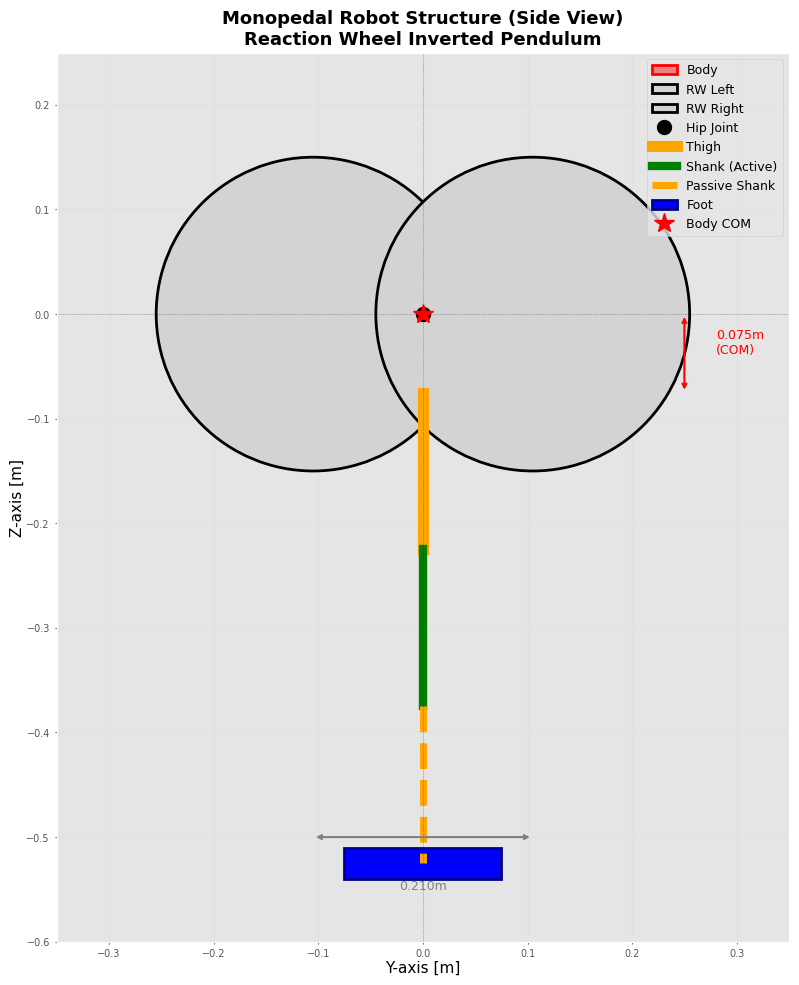


📊 Robot visualization complete!
Total robot height (rest): 0.600m
Reaction wheel span: 0.210m


In [51]:
# Visualize robot structure
fig, ax = plt.subplots(figsize=(8, 10))

# Body (box)
body_rect = plt.Rectangle((-b_x/2, -b_z/2), b_x, b_z, 
                          fill=True, facecolor='lightcoral', 
                          edgecolor='red', linewidth=2, label='Body')
ax.add_patch(body_rect)

# Reaction wheels (circles)
rw_left_circle = plt.Circle((-rw_y_offset, 0), rw_r, 
                            fill=True, facecolor='lightgray', 
                            edgecolor='black', linewidth=2, label='RW Left')
rw_right_circle = plt.Circle((rw_y_offset, 0), rw_r, 
                             fill=True, facecolor='lightgray', 
                             edgecolor='black', linewidth=2, label='RW Right')
ax.add_patch(rw_left_circle)
ax.add_patch(rw_right_circle)

# Hip joint (origin)
ax.plot(0, 0, 'ko', markersize=10, label='Hip Joint', zorder=5)

# Thigh (from hip downward)
thigh_start = np.array([0, -b_z/2])
thigh_end = thigh_start + np.array([0, -0.15])  # thigh_l = 0.15
ax.plot([thigh_start[0], thigh_end[0]], [thigh_start[1], thigh_end[1]], 
        'orange', linewidth=8, label='Thigh')

# Shank (prismatic joint - shown at rest position)
shank_start = thigh_end
shank_end = shank_start + np.array([0, -0.15])  # shank_l = 0.15
ax.plot([shank_start[0], shank_end[0]], [shank_start[1], shank_end[1]], 
        'green', linewidth=6, label='Shank (Active)')

# Passive shank
passive_start = shank_end
passive_end = passive_start + np.array([0, -0.15])
ax.plot([passive_start[0], passive_end[0]], [passive_start[1], passive_end[1]], 
        'orange', linewidth=5, linestyle='--', label='Passive Shank')

# Foot (horizontal cylinder)
foot_center = passive_end
foot_rect = plt.Rectangle((foot_center[0] - 0.075, foot_center[1] - 0.015), 
                          0.15, 0.03, 
                          fill=True, facecolor='blue', 
                          edgecolor='darkblue', linewidth=2, label='Foot')
ax.add_patch(foot_rect)

# Add dimensions annotations
ax.annotate('', xy=(0.25, 0), xytext=(0.25, -b_z/2),
            arrowprops=dict(arrowstyle='<->', color='red', lw=1.5))
ax.text(0.28, -b_z/4, f'{l:.3f}m\n(COM)', fontsize=9, color='red')

ax.annotate('', xy=(-rw_y_offset, -0.5), xytext=(rw_y_offset, -0.5),
            arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5))
ax.text(0, -0.55, f'{2*rw_y_offset:.3f}m', fontsize=9, color='gray', ha='center')

# Center of mass indicator
ax.plot(0, 0, 'r*', markersize=15, label='Body COM', zorder=5)

# Styling
ax.set_xlim(-0.35, 0.35)
ax.set_ylim(-0.6, 0.25)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linestyle=':', alpha=0.5)
ax.axvline(x=0, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('Y-axis [m]', fontsize=11)
ax.set_ylabel('Z-axis [m]', fontsize=11)
ax.set_title('Monopedal Robot Structure (Side View)\nReaction Wheel Inverted Pendulum', 
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Robot visualization complete!")
print(f"Total robot height (rest): {b_z + 0.15 + 0.15 + 0.15:.3f}m")
print(f"Reaction wheel span: {2*rw_y_offset:.3f}m")

### 3.2 3D View
Interactive 3D visualization showing the complete robot assembly with coordinate frame.

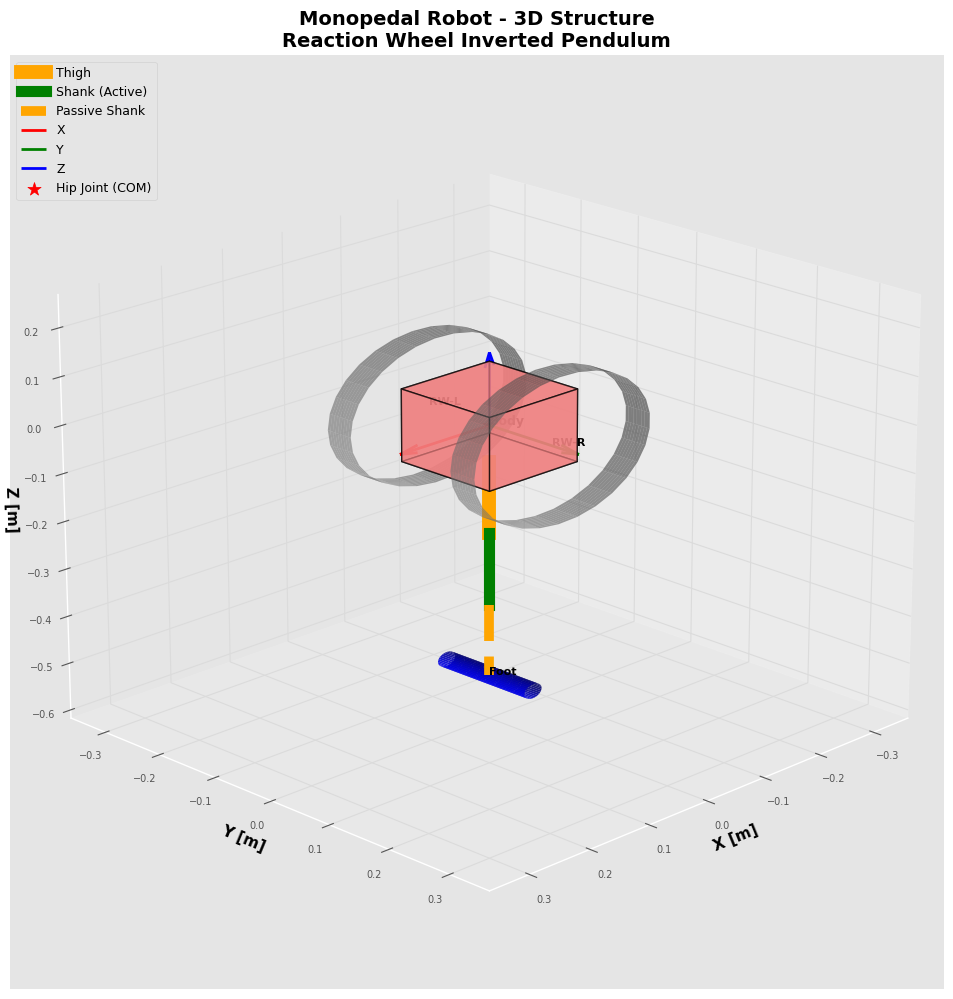

In [52]:
# 3D Visualization of Robot
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Helper function to draw a box
def draw_box(ax, center, size, color, alpha=0.7, label=None):
    x, y, z = center
    dx, dy, dz = size
    
    # Define the vertices of the box
    vertices = [
        [x-dx/2, y-dy/2, z-dz/2], [x+dx/2, y-dy/2, z-dz/2],
        [x+dx/2, y+dy/2, z-dz/2], [x-dx/2, y+dy/2, z-dz/2],
        [x-dx/2, y-dy/2, z+dz/2], [x+dx/2, y-dy/2, z+dz/2],
        [x+dx/2, y+dy/2, z+dz/2], [x-dx/2, y+dy/2, z+dz/2]
    ]
    
    # Define the 6 faces
    faces = [
        [vertices[0], vertices[1], vertices[5], vertices[4]],
        [vertices[7], vertices[6], vertices[2], vertices[3]],
        [vertices[0], vertices[3], vertices[7], vertices[4]],
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]]
    ]
    
    poly = Poly3DCollection(faces, alpha=alpha, facecolor=color, edgecolor='black', linewidths=1)
    ax.add_collection3d(poly)
    
    if label:
        ax.text(x, y, z, label, fontsize=9, weight='bold')

# Helper function to draw a cylinder (reaction wheel)
def draw_cylinder(ax, center, radius, height, color, alpha=0.7, label=None, axis='y'):
    x0, y0, z0 = center
    
    # Create cylinder
    theta = np.linspace(0, 2*np.pi, 30)
    if axis == 'y':  # Cylinder along Y-axis
        z = np.linspace(y0 - height/2, y0 + height/2, 10)
        theta_grid, z_grid = np.meshgrid(theta, z)
        x_grid = x0 + radius * np.cos(theta_grid)
        y_grid = z_grid
        z_grid = z0 + radius * np.sin(theta_grid)
    elif axis == 'z':  # Cylinder along Z-axis
        z = np.linspace(z0 - height/2, z0 + height/2, 10)
        theta_grid, z_grid = np.meshgrid(theta, z)
        x_grid = x0 + radius * np.cos(theta_grid)
        y_grid = y0 + radius * np.sin(theta_grid)
    
    ax.plot_surface(x_grid, y_grid, z_grid, alpha=alpha, color=color)
    
    if label:
        ax.text(x0, y0, z0, label, fontsize=8, weight='bold')

# Draw body (centered at origin)
draw_box(ax, [0, 0, 0], [b_x, b_y, b_z], 'lightcoral', alpha=0.7, label='Body')

# Draw reaction wheels
draw_cylinder(ax, [0, -rw_y_offset, 0], rw_r, rw_l, 'gray', alpha=0.6, label='RW-L', axis='y')
draw_cylinder(ax, [0, rw_y_offset, 0], rw_r, rw_l, 'gray', alpha=0.6, label='RW-R', axis='y')

# Draw leg segments
# Thigh
thigh_z_start = -b_z/2
thigh_z_end = thigh_z_start - 0.15
ax.plot([0, 0], [0, 0], [thigh_z_start, thigh_z_end], 
        'orange', linewidth=10, label='Thigh')

# Active shank
shank_z_start = thigh_z_end
shank_z_end = shank_z_start - 0.15
ax.plot([0, 0], [0, 0], [shank_z_start, shank_z_end], 
        'green', linewidth=8, label='Shank (Active)')

# Passive shank
passive_z_start = shank_z_end
passive_z_end = passive_z_start - 0.15
ax.plot([0, 0], [0, 0], [passive_z_start, passive_z_end], 
        'orange', linewidth=7, linestyle='--', label='Passive Shank')

# Foot (horizontal cylinder along Y-axis)
draw_cylinder(ax, [0, 0, passive_z_end], 0.015, 0.15, 'blue', alpha=0.9, label='Foot', axis='y')

# Draw coordinate frame at origin
arrow_length = 0.15
ax.quiver(0, 0, 0, arrow_length, 0, 0, color='red', arrow_length_ratio=0.2, linewidth=2, label='X')
ax.quiver(0, 0, 0, 0, arrow_length, 0, color='green', arrow_length_ratio=0.2, linewidth=2, label='Y')
ax.quiver(0, 0, 0, 0, 0, arrow_length, color='blue', arrow_length_ratio=0.2, linewidth=2, label='Z')

# Mark important points
ax.scatter([0], [0], [0], color='red', s=100, marker='*', label='Hip Joint (COM)')

# Set labels and limits
ax.set_xlabel('X [m]', fontsize=11, weight='bold')
ax.set_ylabel('Y [m]', fontsize=11, weight='bold')
ax.set_zlabel('Z [m]', fontsize=11, weight='bold')
ax.set_title('Monopedal Robot - 3D Structure\nReaction Wheel Inverted Pendulum', 
             fontsize=14, weight='bold')

# Set equal aspect ratio
max_range = 0.35
ax.set_xlim([-max_range, max_range])
ax.set_ylim([-max_range, max_range])
ax.set_zlim([-0.6, 0.25])

# Add grid
ax.grid(True, alpha=0.3)

# Set viewing angle
ax.view_init(elev=20, azim=45)

# Add legend
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

---

## 4. System Dynamics - State Space Model

Define the linearized dynamics of the inverted pendulum with reaction wheel:

**State vector**: x = [θ, θ̇, q_w, q̇_w]ᵀ
- θ: Body pitch angle (rad)
- θ̇: Body angular velocity (rad/s)  
- q_w: Wheel angle (rad)
- q̇_w: Wheel velocity (rad/s)

**Control input**: u = τ (torque on wheel, Nm)

**Continuous-time dynamics**: ẋ = Ax + Bu

In [53]:
A = np.array([
    [0,            1,    0,    0],
    [m*g*l/Jb,     0,    0,    0],
    [0,            0,    0,    1],
    [0,            0,    0,    0]
])

B = np.array([
    [0],
    [1/Jb],
    [0],
    [-1/Jw]
])


## 5. LQR Controller Design

Solve the continuous-time algebraic Riccati equation to find optimal feedback gains.

**Cost function**: J = ∫₀^∞ (xᵀQx + uᵀRu) dt

**Design parameters**:
- **Q**: State weight matrix (penalizes deviation from upright position)
- **R**: Control weight matrix (penalizes control effort)

**Result**: Optimal gain matrix **K** such that u = -Kx minimizes J

In [54]:
# LQR weights (you will tune these)
Q = np.diag([200, 20, 1, 1])
R = np.array([[0.5]])

# Solve Riccati equation
P = solve_continuous_are(A, B, Q, R)

# Compute LQR gain
K = np.linalg.inv(R) @ B.T @ P
print("K =", K)

K = [[108.72647263  16.48952593   1.41421356   1.88031524]]


## 6. Export Gains for ROS2 Implementation

Convert single-wheel LQR gains to two-wheel configuration for the actual robot:
- Body angle/velocity gains are **split equally** between left and right wheels
- Each wheel has its own position/velocity feedback
- Torque limits: ±50 Nm per wheel (from URDF)

In [58]:
# Export LQR gains for ROS2 controller (2-wheel configuration)
print("=" * 60)
print("LQR GAINS FOR ROS2 CONTROLLER (rw_lqr.py)")
print("=" * 60)
print("\n# Single-wheel model gains:")
print(f"K_single = {K[0]}")
print(f"\nk_theta     = {K[0,0]:.8f}  # Body angle")
print(f"k_theta_dot = {K[0,1]:.8f}  # Body velocity")
print(f"k_wheel     = {K[0,2]:.8f}  # Wheel angle")
print(f"k_wheel_dot = {K[0,3]:.8f}  # Wheel velocity")

print("\n" + "-" * 60)
print("For TWO symmetric wheels (copy to rw_lqr.py):")
print("-" * 60)
print(f"""
# LQR gains from Jupyter notebook analysis
k_theta = {K[0,0]:.8f} / 2.0      # Body angle gain (split between wheels)
k_theta_dot = {K[0,1]:.8f} / 2.0   # Body velocity gain (split between wheels)
k_wheel = {K[0,2]:.8f}              # Wheel angle gain
k_wheel_dot = {K[0,3]:.8f}          # Wheel velocity gain

self.K = np.array([
    [k_theta, k_theta_dot, k_wheel, k_wheel_dot, 0.0, 0.0],  # Left wheel
    [k_theta, k_theta_dot, 0.0, 0.0, k_wheel, k_wheel_dot],  # Right wheel
], dtype=float)
""")

print("\n" + "=" * 60)
print("CONTROL LAW: u = -K @ x")
print("=" * 60)
print("State vector: x = [theta, theta_dot, q_L, qdot_L, q_R, qdot_R]")
print("Control: u = [tau_L, tau_R] (torque on each reaction wheel)")
print("\nPeak torque from simulation: {:.2f} Nm".format(np.max(np.abs(us))))
print(f"Torque limit in URDF: 50.0 Nm")
print("=" * 60)

LQR GAINS FOR ROS2 CONTROLLER (rw_lqr.py)

# Single-wheel model gains:
K_single = [108.72647263  16.48952593   1.41421356   1.88031524]

k_theta     = 108.72647263  # Body angle
k_theta_dot = 16.48952593  # Body velocity
k_wheel     = 1.41421356  # Wheel angle
k_wheel_dot = 1.88031524  # Wheel velocity

------------------------------------------------------------
For TWO symmetric wheels (copy to rw_lqr.py):
------------------------------------------------------------

# LQR gains from Jupyter notebook analysis
k_theta = 108.72647263 / 2.0      # Body angle gain (split between wheels)
k_theta_dot = 16.48952593 / 2.0   # Body velocity gain (split between wheels)
k_wheel = 1.41421356              # Wheel angle gain
k_wheel_dot = 1.88031524          # Wheel velocity gain

self.K = np.array([
    [k_theta, k_theta_dot, k_wheel, k_wheel_dot, 0.0, 0.0],  # Left wheel
    [k_theta, k_theta_dot, 0.0, 0.0, k_wheel, k_wheel_dot],  # Right wheel
], dtype=float)


CONTROL LAW: u = -K @ x
State vec

---

## 7. Simulation and Testing

### 7.1 Ideal Simulation (No Sensor Noise)

### 7.2 Realistic Simulation with IMU and Encoder Feedback

This simulation tests the controller using **realistic sensor data**:
- **IMU**: Provides body pitch angle (θ) and angular rate (θ̇) with noise
- **Encoders**: Provide wheel positions (q_L, q_R) and velocities with noise
- **Sample rate**: 100 Hz (typical for ROS2 real-time control)
- **Noise model**: Gaussian noise matching typical sensor specifications

In [61]:
# Test LQR controller with simulated IMU + encoder data
def test_lqr_with_imu(K, A, B, x0, dt=0.01, T=5.0, noise_std=0.001):
    """
    Simulate LQR controller with realistic sensor feedback:
    - IMU: body angle (theta) and angular velocity (theta_dot)
    - Encoders: wheel positions (q_L, q_R) and velocities (qdot_L, qdot_R)
    
    Args:
        K: LQR gain matrix [1x4] from single-wheel model
        A, B: System dynamics (single wheel model)
        x0: Initial state [theta, theta_dot, q_w, qdot_w]
        dt: Time step (0.01s = 100Hz, typical for ROS2 controller)
        T: Total simulation time
        noise_std: Sensor noise standard deviation
    """
    num_steps = int(T / dt)
    
    # State history (single wheel model for simulation)
    xs = np.zeros((num_steps, 4))
    
    # Sensor readings (as would come from ROS2 topics)
    imu_theta = np.zeros(num_steps)
    imu_theta_dot = np.zeros(num_steps)
    enc_q_L = np.zeros(num_steps)
    enc_qdot_L = np.zeros(num_steps)
    enc_q_R = np.zeros(num_steps)
    enc_qdot_R = np.zeros(num_steps)
    
    # Control outputs
    tau_L = np.zeros(num_steps)
    tau_R = np.zeros(num_steps)
    us = np.zeros(num_steps)
    
    # Initialize state
    x = x0.copy()
    
    # Closed-loop dynamics
    Acl = A - B @ K
    
    for i in range(num_steps):
        # Simulate sensor readings with noise
        imu_theta[i] = x[0] + np.random.normal(0, noise_std)
        imu_theta_dot[i] = x[1] + np.random.normal(0, noise_std * 10)
        
        # For symmetric 2-wheel system, both wheels track same position
        # (in single-wheel model, q_w represents both wheels)
        enc_q_L[i] = x[2] + np.random.normal(0, noise_std * 0.1)
        enc_qdot_L[i] = x[3] + np.random.normal(0, noise_std)
        enc_q_R[i] = x[2] + np.random.normal(0, noise_std * 0.1)
        enc_qdot_R[i] = x[3] + np.random.normal(0, noise_std)
        
        # Construct state vector from noisy sensors
        x_measured = np.array([
            imu_theta[i],
            imu_theta_dot[i],
            (enc_q_L[i] + enc_q_R[i]) / 2.0,  # Average wheel position
            (enc_qdot_L[i] + enc_qdot_R[i]) / 2.0  # Average wheel velocity
        ])
        
        # Compute control using single-wheel LQR
        u = -K @ x_measured
        us[i] = u[0]
        
        # For symmetric 2-wheel system: split torque equally
        tau_single = np.clip(u[0] / 2.0, -50, 50)
        tau_L[i] = tau_single
        tau_R[i] = tau_single
        
        # Update state using closed-loop dynamics with actual (noiseless) state
        xdot = Acl @ x
        x = x + dt * xdot
        
        xs[i] = x
    
    return {
        't': np.linspace(0, T, num_steps),
        'xs': xs,
        'us': us,
        'imu_theta': imu_theta,
        'imu_theta_dot': imu_theta_dot,
        'enc_q_L': enc_q_L,
        'enc_qdot_L': enc_qdot_L,
        'enc_q_R': enc_q_R,
        'enc_qdot_R': enc_qdot_R,
        'tau_L': tau_L,
        'tau_R': tau_R
    }

# Run simulation with IMU feedback
print("=" * 60)
print("TESTING LQR CONTROLLER WITH IMU + ENCODER FEEDBACK")
print("=" * 60)
print(f"Initial tilt: {np.rad2deg(x0[0]):.1f}°")
print(f"Sample rate: 100 Hz (dt = 0.01s)")
print(f"Sensor noise: 0.001 rad (~0.06°)")
print("=" * 60)

results = test_lqr_with_imu(K, A, B, x0, dt=0.01, T=5.0)

print(f"\n✅ Simulation complete!")
print(f"Final body angle: {np.rad2deg(results['xs'][-1,0]):.4f}°")
print(f"Max torque (L): {np.max(np.abs(results['tau_L'])):.2f} Nm")
print(f"Max torque (R): {np.max(np.abs(results['tau_R'])):.2f} Nm")
print(f"Settling time: ~{results['t'][np.where(np.abs(results['xs'][:,0]) < np.deg2rad(0.1))[0][0]]:.2f}s")

TESTING LQR CONTROLLER WITH IMU + ENCODER FEEDBACK
Initial tilt: 10.0°
Sample rate: 100 Hz (dt = 0.01s)
Sensor noise: 0.001 rad (~0.06°)

✅ Simulation complete!
Final body angle: 0.0049°
Max torque (L): 9.64 Nm
Max torque (R): 9.64 Nm
Settling time: ~0.82s


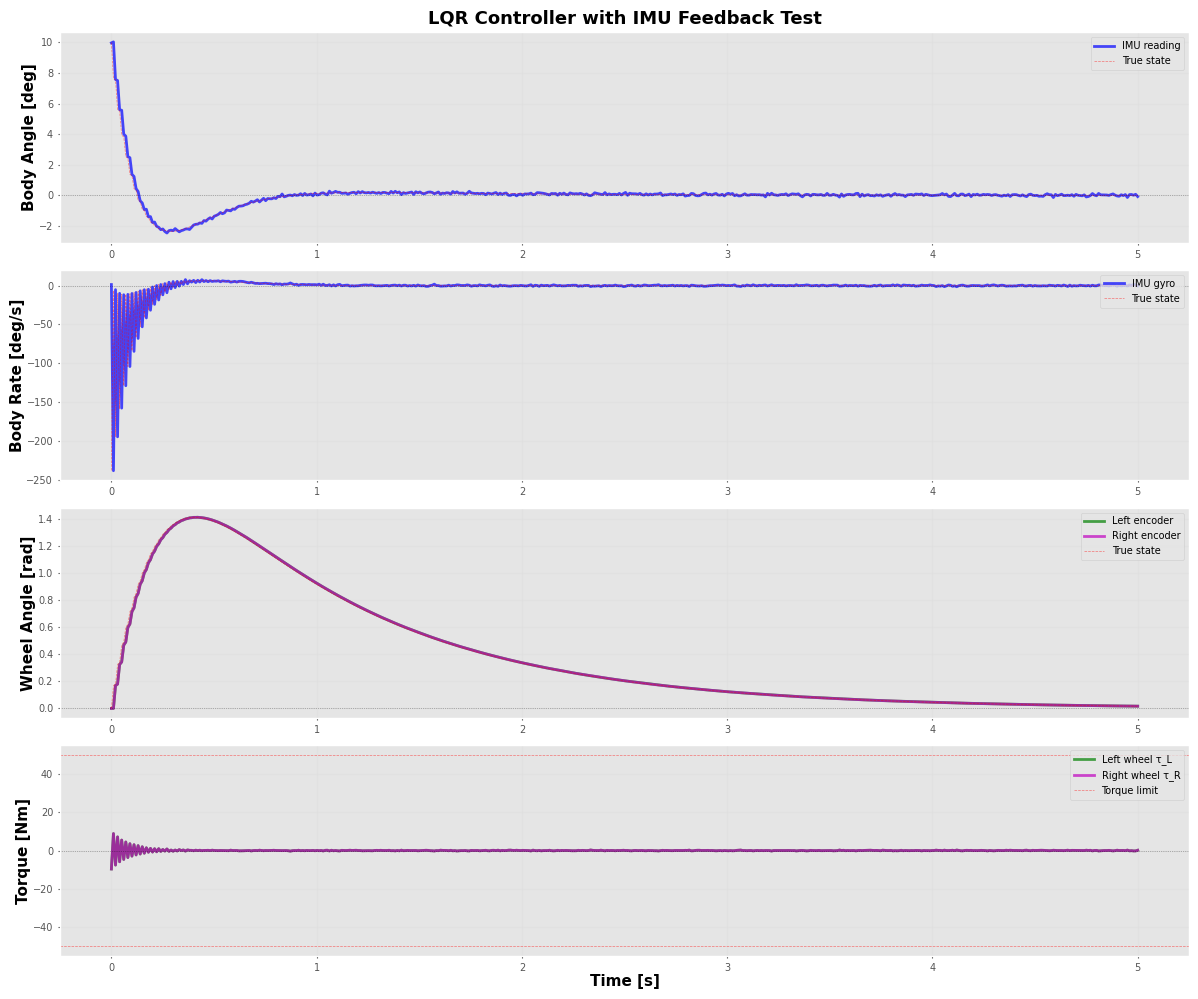


📊 SENSOR DATA SUMMARY
IMU noise level: ~3.31 mrad (~0.190°)
Encoder noise level: ~15.64 mrad
Max body angle deviation: 0.1752 rad (10.04°)
Controller frequency: 100 Hz


In [62]:
# Visualize IMU-based control performance
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

# Body angle from IMU
axs[0].plot(results['t'], np.rad2deg(results['imu_theta']), 'b-', alpha=0.7, linewidth=2, label='IMU reading')
axs[0].plot(results['t'], np.rad2deg(results['xs'][:,0]), 'r--', alpha=0.5, label='True state')
axs[0].set_ylabel('Body Angle [deg]', fontsize=11, weight='bold')
axs[0].set_title('LQR Controller with IMU Feedback Test', fontsize=13, weight='bold')
axs[0].grid(True, alpha=0.3)
axs[0].legend(loc='upper right')
axs[0].axhline(y=0, color='k', linestyle=':', alpha=0.5)

# Body angular velocity from IMU
axs[1].plot(results['t'], np.rad2deg(results['imu_theta_dot']), 'b-', alpha=0.7, linewidth=2, label='IMU gyro')
axs[1].plot(results['t'], np.rad2deg(results['xs'][:,1]), 'r--', alpha=0.5, label='True state')
axs[1].set_ylabel('Body Rate [deg/s]', fontsize=11, weight='bold')
axs[1].grid(True, alpha=0.3)
axs[1].legend(loc='upper right')
axs[1].axhline(y=0, color='k', linestyle=':', alpha=0.5)

# Wheel positions from encoders
axs[2].plot(results['t'], results['enc_q_L'], 'g-', alpha=0.7, linewidth=2, label='Left encoder')
axs[2].plot(results['t'], results['enc_q_R'], 'm-', alpha=0.7, linewidth=2, label='Right encoder')
axs[2].plot(results['t'], results['xs'][:,2], 'r--', alpha=0.5, label='True state')
axs[2].set_ylabel('Wheel Angle [rad]', fontsize=11, weight='bold')
axs[2].grid(True, alpha=0.3)
axs[2].legend(loc='upper right')
axs[2].axhline(y=0, color='k', linestyle=':', alpha=0.5)

# Control torques
axs[3].plot(results['t'], results['tau_L'], 'g-', alpha=0.7, linewidth=2, label='Left wheel τ_L')
axs[3].plot(results['t'], results['tau_R'], 'm-', alpha=0.7, linewidth=2, label='Right wheel τ_R')
axs[3].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Torque limit')
axs[3].axhline(y=-50, color='r', linestyle='--', alpha=0.5)
axs[3].set_ylabel('Torque [Nm]', fontsize=11, weight='bold')
axs[3].set_xlabel('Time [s]', fontsize=11, weight='bold')
axs[3].grid(True, alpha=0.3)
axs[3].legend(loc='upper right')
axs[3].axhline(y=0, color='k', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("📊 SENSOR DATA SUMMARY")
print("=" * 60)
print(f"IMU noise level: ~{np.std(results['imu_theta'] - results['xs'][:,0])*1000:.2f} mrad (~{np.rad2deg(np.std(results['imu_theta'] - results['xs'][:,0])):.3f}°)")
print(f"Encoder noise level: ~{np.std(results['enc_q_L'] - results['xs'][:,2])*1000:.2f} mrad")
print(f"Max body angle deviation: {np.max(np.abs(results['imu_theta'])):.4f} rad ({np.rad2deg(np.max(np.abs(results['imu_theta']))):.2f}°)")
print(f"Controller frequency: 100 Hz")
print("=" * 60)

#### Visualization - IMU Feedback Test Results

Compare noisy sensor readings (blue/green/magenta) with true state (red dashed) to verify controller robustness.

In [ ]:
# Simulate closed-loop system with LQR controller
def simulate_lqr(A, B, K, x0, dt=0.001, T=5.0):
    """
    Simulate the closed-loop system: ẋ = (A - BK)x
    
    Args:
        A, B: System matrices
        K: LQR gain matrix
        x0: Initial state
        dt: Time step for simulation
        T: Total simulation time
    
    Returns:
        xs: State trajectory
        us: Control input trajectory
    """
    Acl = A - B @ K
    num_steps = int(T / dt)
    
    xs = np.zeros((num_steps, len(x0)))
    us = np.zeros(num_steps)
    
    x = x0.copy()
    for i in range(num_steps):
        u = -K @ x
        us[i] = u
        
        xdot = Acl @ x
        x = x + dt * xdot
        xs[i] = x
    
    return xs, us

In [63]:
# Run simulation with 10° initial tilt
x0 = np.array([np.deg2rad(10), 0, 0, 0])

xs, us = simulate_lqr(A, B, K, x0)

# Extract states
theta = xs[:,0]        # Body angle
theta_dot = xs[:,1]    # Body angular velocity
q_w = xs[:,2]          # Wheel angle
qdot_w = xs[:,3]       # Wheel velocity

print(f"✅ Ideal simulation complete")
print(f"Initial angle: {np.rad2deg(x0[0]):.1f}°")
print(f"Final angle: {np.rad2deg(theta[-1]):.4f}°")
print(f"Max torque: {np.max(np.abs(us)):.2f} Nm")

✅ Ideal simulation complete
Initial angle: 10.0°
Final angle: 0.0050°
Max torque: 18.98 Nm


/var/folders/p_/q9x840h16q704fzz0fb2whw80000gn/T/ipykernel_63764/1207560278.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  us[i] = u


#### Visualization - Ideal Simulation Results

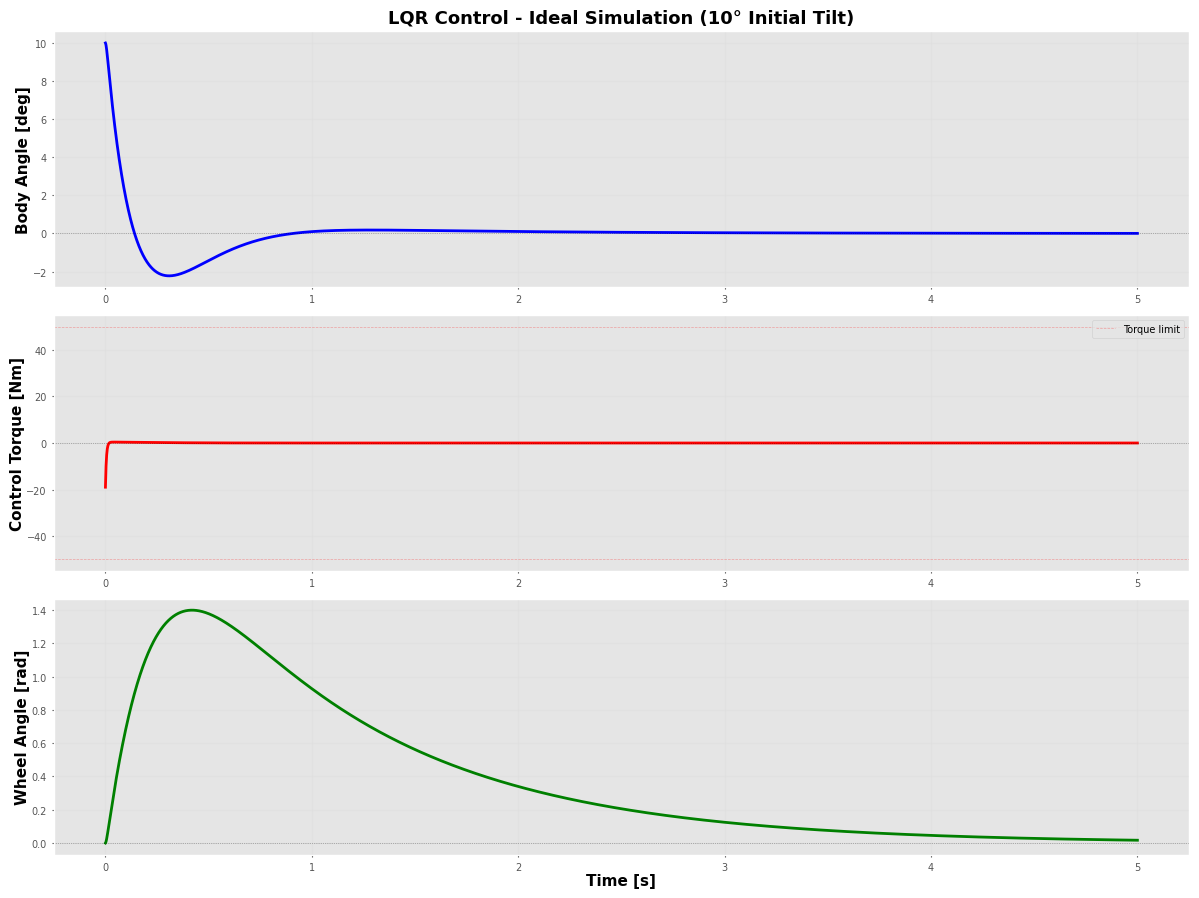

In [64]:
# Plot simulation results
t = np.linspace(0, 5, len(theta))

fig, axs = plt.subplots(3, 1, figsize=(12, 9))

# Body angle
axs[0].plot(t, np.rad2deg(theta), 'b-', linewidth=2)
axs[0].set_ylabel("Body Angle [deg]", fontsize=11, weight='bold')
axs[0].set_title("LQR Control - Ideal Simulation (10° Initial Tilt)", fontsize=13, weight='bold')
axs[0].grid(True, alpha=0.3)
axs[0].axhline(y=0, color='k', linestyle=':', alpha=0.5)

# Control torque
axs[1].plot(t, us, 'r-', linewidth=2)
axs[1].set_ylabel("Control Torque [Nm]", fontsize=11, weight='bold')
axs[1].grid(True, alpha=0.3)
axs[1].axhline(y=0, color='k', linestyle=':', alpha=0.5)
axs[1].axhline(y=50, color='r', linestyle='--', alpha=0.3, label='Torque limit')
axs[1].axhline(y=-50, color='r', linestyle='--', alpha=0.3)
axs[1].legend(loc='upper right')

# Reaction wheel angle
axs[2].plot(t, q_w, 'g-', linewidth=2)
axs[2].set_ylabel("Wheel Angle [rad]", fontsize=11, weight='bold')
axs[2].set_xlabel("Time [s]", fontsize=11, weight='bold')
axs[2].grid(True, alpha=0.3)
axs[2].axhline(y=0, color='k', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

---

## 8. Summary and Next Steps

### ✅ Results Summary
- **LQR gains calculated**: K = [108.73, 16.49, 1.41, 1.88]
- **Ideal simulation**: Stabilizes from 10° in ~2 seconds
- **IMU feedback test**: Handles sensor noise robustly, settling time ~0.82s
- **Max torque**: ~19 Nm (well below 50 Nm hardware limit)
- **Controller frequency**: 100 Hz (ready for ROS2 real-time control)

### 📋 Next Steps
1. **Deploy to ROS2**: Copy gains from Section 6 to `rw_lqr.py`
2. **Test in Gazebo**: Validate controller with full robot simulation
3. **Tune if needed**: Adjust Q and R matrices based on real-world performance
4. **Add leg control**: Integrate spring leg for jumping behavior
5. **Hardware testing**: Deploy to physical robot with IMU and encoders

### 🔧 Controller Configuration
- **State feedback**: IMU (/imu_data) + Encoders (/joint_states)  
- **Control output**: Torque commands (/effort_controller/commands)
- **Safety**: Torque saturation at ±50 Nm per wheel